In [1]:
# import all packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# set display options
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
kwargs = dict(skipinitialspace=False,engine='c',encoding='ISO-8859-1')


import gc

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

## Read in Dataset

In [2]:
%%time

df = pd.read_csv('../10262021_Update_Eng/yoy_hp_dem_util_cahps.csv')
df.drop(["yoy_Part_D_eligible","yoy_Part_C_eligible","yoy_Full_eligible"],axis=1,inplace=True)

rename_dict = {
    '100104':'Diabetes - Eye',
    '100107':'Diabetes - Kidney',
    '101201':'Rheumatoid Arthritis',
    '101603':'Breast Cancer Screening',
    '102401':'Colorectal Cancer',
    '104201':'Osteo Screening',
    '107107':'Medication Reconciliation Post Discharge',
    '107110':'Adult BMI',
    '107125':'SNP - Medication',
    '107126':'SNP - Functional Status Assessment',
    '107127':'SNP - Pain Screening',
    '201180':'Statin Adherence',
    '201181':'ACEI/ARB Adherence',
    '201182':'Diabetes Adherence',
    '201183':'Statin use in Diabetes',
    '201184':'Medication Therapy Management',
    '201507':'Statin Therapy for Patients with CD',
    '999998':'Diabetes - Blood Sugar Controlled'
}

df.rename(columns=rename_dict,inplace=True)

print(df.shape)

(4995430, 187)
Wall time: 2min 19s


## Select In/dependent variables

In [3]:
# Dependent variables
# TARGET_COLS = ['201181','999998','201183','201182']
TARGET_COLS = [
'Diabetes - Eye',
'Diabetes - Kidney',
'Rheumatoid Arthritis',
'Breast Cancer Screening',
'Colorectal Cancer',
'Osteo Screening',
'Medication Reconciliation Post Discharge',
'Adult BMI',
'SNP - Medication',
'SNP - Functional Status Assessment',
'SNP - Pain Screening',
'Statin Adherence',
'ACEI/ARB Adherence',
'Diabetes Adherence',
'Statin use in Diabetes',
'Medication Therapy Management',
'Statin Therapy for Patients with CD',
'Diabetes - Blood Sugar Controlled'
]
# df.dropna(subset=TARGET_COLS,
#           thresh=1,
#           inplace=True)
df[TARGET_COLS].describe()

,Diabetes - Eye,Diabetes - Kidney,Rheumatoid Arthritis,Breast Cancer Screening,Colorectal Cancer,Osteo Screening,Medication Reconciliation Post Discharge,Adult BMI,SNP - Medication,SNP - Functional Status Assessment,SNP - Pain Screening,Statin Adherence,ACEI/ARB Adherence,Diabetes Adherence,Statin use in Diabetes,Medication Therapy Management,Statin Therapy for Patients with CD,Diabetes - Blood Sugar Controlled
count,739880.000,733365.000,39182.000,779879.000,2012695.000,17687.000,209655.000,768792.000,84135.000,41799.000,84135.000,2183350.000,1950171.000,686252.000,582169.000,287735.000,222110.000,739880.000
mean,0.649,0.933,0.774,0.716,0.647,0.516,0.802,0.770,0.792,0.882,0.764,0.869,0.881,0.863,0.821,0.757,0.818,0.525
std,0.477,0.250,0.418,0.451,0.478,0.500,0.398,0.421,0.406,0.323,0.425,0.337,0.324,0.344,0.383,0.429,0.386,0.499
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000
50%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
75%,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [4]:
# Independent variables
cols = [
'MEDICARE_NUMBER',
# 'Member_ID',
# 'Eff_Date',
# 'Term_Date',
# 'Mbr_Mths',
# 'Contract_Number',
# 'PBP',
# 'Product',
# 'CMS_County',
# 'CMS_State',
# 'NEW_REGION',
# 'MA_Territory',
# 'DOB',
'Age',
'Gender',
# 'Zip',
# 'FIPS',
'Plan_Type',
# 'dual_Status',
# 'PCP_Name',
# 'PCP_Tax_ID',
# 'GroupName',
# 'GroupNumber',
# 'GroupSegment',
# 'GroupSegmentName',
# 'TRR_Parent_Name',
# 'TOH_Name',
# 'Recruiter_Name',
# 'Writing_Agent_Name',
# 'Sales_Channel',
# 'New_Market',
'SNP',
'LIS_Flag',
# 'Enroll_Status',
# 'Issued_Status',
# 'Group_Status',
# 'AEP2018_Denom',
# 'AEP2018_Lapse',
'YEAR',
# 'AEP2019_Denom',
# 'AEP2019_Lapse',
# 'AEP2020_Denom',
# 'AEP2020_Lapse',
# 'AEP2021_Denom',
# 'AEP2021_Lapse',
'yoys',
# 'has_dem',
# 'SRC_MEMBER_ID_x',
# 'RUNYEAR',
# 'ITERATION',
# 'GNC_Den_Final',
# 'GACQ_Den_Final',
# 'HPCS_Den_Final',
# 'GNP_Den_Final',
# 'CC_Den_Final',
# 'Plan_R_Den_Final',
# 'Care_R_Den_Final',
# 'RX_R_Den_Final',
# 'GNC',
# 'GACQ',
# 'HPCS',
# 'GNP',
# 'CC',
# 'Plan_R',
# 'Care_R',
# 'RX_R',
# 'RX_Rating_Class',
# 'CARE_Rating_Class',
# 'PLAN_Rating_Class',
# 'GNC_Class',
# 'GCQ_Class',
# 'CS_Class',
# 'CC_Class',
# 'GNP_Class',
# 'PERIOD_STUDIED',
# 'dem_year',
# 'has_cahps',
# 'HICN_NBR',
# '100104',
# '100107',
# '101201',
# '101603',
# '102401',
# '104201',
# '107107',
# '107110',
# '107125',
# '107126',
# '107127',
# '201180',
# '201181',
# '201182',
# '201183',
# '201184',
# '201507',
# '999998',
# 'HP_YEAR',
# '101803',
# '600070',
# 'has_hp',
# 'SRC_MEMBER_ID_y',
# 'EMERG_TRANSACTIONS',
# 'PCP_TRANSACTIONS',
# 'SPCLST_TRANSACTIONS',
# 'IP_TRANSACTIONS',
'EMERG_VISITS',
'PRIMARY_CARE_VISITS',
'SPCLST_VISITS',
'IP_VISITS',
# 'PREVENTIVE_CARE_VISITS',
'EMERG_BENEFIT_PAID_AMT',
'PCP_BENEFIT_PAID_AMT',
'SPCLST_BENEFIT_PAID_AMT',
'IP_BENEFIT_PAID_AMT',
'EMERG_MBR_PAID_AMT',
'PCP_MBR_PAID_AMT',
'SPCLST_MBR_PAID_AMT',
'IP_MBR_PAID_AMT',
# 'PAR_MED_CLAIM_COUNT',
# 'NONPAR_MED_CLAIM_COUNT',
# 'PAR_MED_VISITS',
# 'NONPAR_MED_VISITS',
# 'PAR_MED_BENEFIT_PAID_AMT',
# 'NONPAR_MED_BENEFIT_PAID_AMT',
# 'PAR_MED_MBR_PAID_AMT',
# 'NONPAR_MED_MBR_PAID_AMT',
'AETNA_MED_PAID_AMT',
'MBR_MED_PAID_AMT',
# 'TOTAL_MED_COST',
# 'MBR_MED_DEDUCTIBLE_PAID_AMT',
# 'PAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
# 'NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
'AMBULANCE_CLAIM_COUNT',
# 'AMBULANCE_EVENT_COUNT',
# 'BEHAVIORAL_HEALTH_CLAIM_COUNT',
# 'BEHAVIORAL_HEALTH_VISITS',
# 'OP_TRANSACTIONS',
# 'OP_VISITS',
# 'OP_BENEFIT_PAID_AMT',
# 'OP_MBR_PAID_AMT',
# 'DR_TRANSACTIONS',
# 'DR_VISITS',
# 'DR_BENEFIT_PAID_AMT',
# 'DR_MBR_PAID_AMT',
# 'VISION_TRANSACTIONS',
# 'VISION_VISITS',
# 'TOTAL_ALLOWED_VISION',
# 'BENEFIT_PAID_VISION',
# 'MEM_PAID_VISION',
# 'PAR_AMT_VISION',
# 'NONPAR_AMT_VISION',
# 'PREV_TRANSACTIONS_DENTAL',
# 'COMP_TRANSACTIONS_DENTAL',
# 'PREV_ALLOWED_DENTAL',
# 'COMP_ALLOWED_DENTAL',
# 'TOTAL_ALLOWED_DENTAL',
# 'PREV_BENEFIT_PAID_DENTAL',
# 'COMP_BENEFIT_PAID_DENTAL',
# 'BENEFIT_PAID_DENTAL',
# 'PREV_MEM_PAID_DENTAL',
# 'COMP_MEM_PAID_DENTAL',
# 'MEM_PAID_DENTAL',
# 'PAR_AMT_DENTAL',
# 'NONPAR_AMT_DENTAL',
# 'PAR_VISITS_DENTAL',
# 'NONPAR_VISITS_DENTAL',
# 'TOTAL_ENCOUNTER_ALLOWED_HEARING',
# 'BENEFIT_ENCOUNTER_PAID_HEARING',
# 'MEM_ENCOUNTER_PAID_HEARING',
# 'TOTAL_ALLOWED_HEARING',
# 'BENEFIT_PAID_HEARING',
# 'MEM_PAID_HEARING',
# 'PAR_AMT_HEARING',
# 'NONPAR_AMT_HEARING',
# 'Order_Count_OTC',
# 'Call_or_Claim_Orders_OTC',
# 'Online_Orders_OTC',
# 'Store_Orders_OTC',
# 'Total_AMT_OTC',
# 'Call_or_Claim_AMT_OTC',
# 'Online_AMT_OTC',
# 'Store_AMT_OTC',
'Benefit_Paid_Amt_OTC',
# 'Mbr_Paid_Amt_OTC',
'has_util',
'PLAN',
# 'PLAN_YOY',
# 'yoy_Full_eligible',
# 'yoy_Part_C_eligible',
# 'yoy_Part_D_eligible'
]
cols.extend(TARGET_COLS)
cols = list(set(cols))
yoy_cols = [
"PLAN","yoys",
# "CONTRACT",
# "PBP",
# "CY_PBPNAME",
# "CY_PRODUCT",
# "PLANTYPE",
# "CY_RENEWALTYPE",
# "CY_OPENACCESS",
# "REGION",
# "MARKET",
# "PLANGEONAME",
# "STATE",
# "CY_PRIMEPLAN",
# "CY_DEDUCTIBLEHMOINN",
# "CY_DEDUCTIBLEPPOANNUAL",
# "CY_DEDUCTIBLEPOSOON",
# "CY_HIGHDEDUCTIBLE",
# "CY_MOOPINN",
# "CY_MOOPCOMBINED",
# "CY_MOOPOON",
# "CY_PREMIUM",
# "CY_PARTBGIVE",
# "CY_INPATIENTSTAYMC",
# "CY_SNF",
# "CY_EMERGENCY",
# "CY_URGENTLYNEEDEDCARE",
# "CY_PCP_MIN",
# "CY_PCP",
# "CY_PCPREASONCD",
# "CY_CHIROPRACTICROUTINE",
# "CY_OCCUPATIONALTHERAPY",
# "CY_PHYSICIANSPECIALIST",
# "CY_DIAGNOSTICPROC",
# "CY_LAB_MIN",
# "CY_LAB",
# "CY_LABREASONCD",
# "CY_DIAGNOSTICRADIOLOGYCT",
# "CY_OUTPATIENTHOSP_MIN",
# "CY_OUTPATIENTHOSP",
# "CY_OUTPATIENTHOSPREASONCD",
# "CY_OUTPATIENTHOSPOBSERVATION_MIN",
# "CY_OUTPATIENTHOSPOBSERVATION",
# "CY_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "CY_ASC",
# "CY_DIALYSIS",
# "CY_ACUPUNCTURE",
# "CY_OTCALLOWANCE",
# "CY_OTCPERIODICITYNMC",
# "CY_FITNESSVENDOR",
# "CY_TELEMONITORING",
# "CY_NURSINGHOTLINE",
# "CY_DENTALBENEFITADMINTYPE",
# "CY_PREVENTIVEDENTALBENTYPE",
# "CY_ORALFREQ",
# "CY_DENTALXRAYSFREQ",
# "CY_PREVDENTALALLOWANCE",
# "CY_PREVDENTALALLOWANCEFREQ",
# "CY_COMPREHENSIVEDENTALNMCBENTYPE",
# "CY_COMPDENTALALLOWANCE",
# "CY_EYEEXAMSMC",
# "CY_EYEEXAMSROUTINE",
# "CY_EYEWEARBENEFITADMINTYPE",
# "CY_EYEWEARNMCBENTYPE",
# "CY_EYEGLASSESFREQ",
# "CY_EYEWEARALLOWANCE",
# "CY_EYEWEARALLOWANCEFREQ",
# "CY_HEARINGEXAMROUTINEFREQ",
# "CY_HEARINGEXAMMC",
# "CY_HEARINGEXAMROUTINE",
# "CY_HEARINGAIDFITTING",
# "CY_HEARINGAIDBENEFITADMINTYPE",
# "CY_HEARINGAIDBENTYPE",
# "CY_HEARINGAIDALLFREQ",
# "CY_HEARINGAIDALLOWANCE",
# "CY_HEARINGAIDALLOWANCETYPE",
# "CY_HEARINGAIDALLOWANCEFREQ",
# "CY_FORMULARYNAME",
# "CY_RXDEDUCTIBLE",
# "CY_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "CY_NETWORK",
# "CY_GAPCOVERAGE",
# "CY_TIER1PREFRETAIL1MO",
# "CY_TIER2PREFRETAIL1MO",
# "CY_TIER3PREFRETAIL1MO",
# "CY_TIER4PREFRETAIL1MO",
# "CY_TIER5PREFRETAIL1MO",
# "CY_TIER1PREFRETAIL3MO",
# "CY_TIER2PREFRETAIL3MO",
# "CY_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "CY_PCP_COSTSHARETYPE",
# "CY_LAB_COSTSHARETYPE",
# "CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "CY_OUTPATIENTHOSP_COSTSHARETYPE",
# "CY_ASC_COSTSHARETYPE",
# "CY_TRANSPORT_BENEFIT",
# "CY_MEAL_BENEFIT",
# "CY_DENTAL_COMBINED",
# "CY_HEARING_COMBINED",
# "CY_EYEWEAR_COMBINED",
# "CY_DENTALBENEFITADMINTYPE_GENERALIZED",
# "CY_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "CY_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "CY_DENTAL_COMBINED_GENERALIZED",
# "CY_HEARING_COMBINED_GENERALIZED",
# "CY_EYEWEAR_COMBINED_GENERALIZED",
# "CY_MEDICALDEDUCTIBLE",
# "NY_PBPNAME",
# "NY_PRODUCT",
# "NY_PLANTYPE",
# "NY_RENEWALTYPE",
# "NY_OPENACCESS",
# "NY_MARKET",
# "NY_PLANGEONAME",
# "NY_STATE",
# "NY_PRIMEPLAN",
# "NY_DEDUCTIBLEHMOINN",
# "NY_DEDUCTIBLEPPOANNUAL",
# "NY_DEDUCTIBLEPOSOON",
"NY_HIGHDEDUCTIBLE",
"NY_MOOPINN",
# "NY_MOOPCOMBINED",
# "NY_MOOPOON",
"NY_PREMIUM",
"NY_PARTBGIVE",
"NY_INPATIENTSTAYMC",
# "NY_SNF",
"NY_EMERGENCY",
# "NY_URGENTLYNEEDEDCARE",
# "NY_PCP_MIN",
"NY_PCP",
# "NY_PCPREASONCD",
# "NY_CHIROPRACTICROUTINE",
# "NY_OCCUPATIONALTHERAPY",
"NY_PHYSICIANSPECIALIST",
# "NY_DIAGNOSTICPROC",
# "NY_LAB_MIN",
"NY_LAB",
# "NY_LABREASONCD",
# "NY_DIAGNOSTICRADIOLOGYCT",
# "NY_OUTPATIENTHOSP_MIN",
"NY_OUTPATIENTHOSP",
# "NY_OUTPATIENTHOSPREASONCD",
# "NY_OUTPATIENTHOSPOBSERVATION_MIN",
# "NY_OUTPATIENTHOSPOBSERVATION",
# "NY_OUTPATIENTHOSPOBSERVATIONREASONCD",
"NY_ASC",
"NY_DIALYSIS",
# "NY_ACUPUNCTURE",
"NY_OTCALLOWANCE",
# "NY_OTCPERIODICITYNMC",
# "NY_FITNESSVENDOR",
# "NY_TELEMONITORING",
# "NY_NURSINGHOTLINE",
# "NY_DENTALBENEFITADMINTYPE",
# "NY_PREVENTIVEDENTALBENTYPE",
# "NY_ORALFREQ",
# "NY_DENTALXRAYSFREQ",
# "NY_PREVDENTALALLOWANCE",
# "NY_PREVDENTALALLOWANCEFREQ",
# "NY_COMPREHENSIVEDENTALNMCBENTYPE",
# "NY_COMPDENTALALLOWANCE",
# "NY_EYEEXAMSMC",
# "NY_EYEEXAMSROUTINE",
# "NY_EYEWEARBENEFITADMINTYPE",
# "NY_EYEWEARNMCBENTYPE",
# "NY_EYEGLASSESFREQ",
# "NY_EYEWEARALLOWANCE",
# "NY_EYEWEARALLOWANCEFREQ",
# "NY_HEARINGEXAMROUTINEFREQ",
# "NY_HEARINGEXAMMC",
# "NY_HEARINGEXAMROUTINE",
# "NY_HEARINGAIDFITTING",
# "NY_HEARINGAIDBENEFITADMINTYPE",
# "NY_HEARINGAIDBENTYPE",
# "NY_HEARINGAIDALLFREQ",
# "NY_HEARINGAIDALLOWANCE",
# "NY_HEARINGAIDALLOWANCETYPE",
# "NY_HEARINGAIDALLOWANCEFREQ",
# "NY_FORMULARYNAME",
"NY_RXDEDUCTIBLE",
# "NY_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "NY_NETWORK",
# "NY_GAPCOVERAGE",
"NY_TIER1PREFRETAIL1MO",
"NY_TIER2PREFRETAIL1MO",
# "NY_TIER3PREFRETAIL1MO",
# "NY_TIER4PREFRETAIL1MO",
# "NY_TIER5PREFRETAIL1MO",
"NY_TIER1PREFRETAIL3MO",
"NY_TIER2PREFRETAIL3MO",
# "NY_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "NY_PCP_COSTSHARETYPE",
# "NY_LAB_COSTSHARETYPE",
# "NY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "NY_OUTPATIENTHOSP_COSTSHARETYPE",
# "NY_ASC_COSTSHARETYPE",
# "NY_TRANSPORT_BENEFIT",
# "NY_MEAL_BENEFIT",
# "NY_DENTAL_COMBINED",
# "NY_HEARING_COMBINED",
# "NY_EYEWEAR_COMBINED",
# "NY_DENTALBENEFITADMINTYPE_GENERALIZED",
# "NY_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "NY_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "NY_DENTAL_COMBINED_GENERALIZED",
# "NY_HEARING_COMBINED_GENERALIZED",
# "NY_EYEWEAR_COMBINED_GENERALIZED",
# "NY_MEDICALDEDUCTIBLE",
# "NY_PLAN",
# "YOY_DIFF_PBPNAME",
# "YOY_DIFF_PRODUCT",
# "YOY_DIFF_RENEWALTYPE",
# "YOY_DIFF_OPENACCESS",
# "YOY_DIFF_PRIMEPLAN",
# "YOY_DIFF_DEDUCTIBLEHMOINN",
# "YOY_DIFF_DEDUCTIBLEPPOANNUAL",
# "YOY_DIFF_DEDUCTIBLEPOSOON",
"YOY_DIFF_HIGHDEDUCTIBLE",
"YOY_DIFF_MOOPINN",
# "YOY_DIFF_MOOPCOMBINED",
# "YOY_DIFF_MOOPOON",
"YOY_DIFF_PREMIUM",
# "YOY_DIFF_PARTBGIVE",
"YOY_DIFF_INPATIENTSTAYMC",
# "YOY_DIFF_SNF",
"YOY_DIFF_EMERGENCY",
# "YOY_DIFF_URGENTLYNEEDEDCARE",
# "YOY_DIFF_PCP_MIN",
"YOY_DIFF_PCP",
# "YOY_DIFF_PCPREASONCD",
# "YOY_DIFF_CHIROPRACTICROUTINE",
# "YOY_DIFF_OCCUPATIONALTHERAPY",
"YOY_DIFF_PHYSICIANSPECIALIST",
# "YOY_DIFF_DIAGNOSTICPROC",
# "YOY_DIFF_LAB_MIN",
"YOY_DIFF_LAB",
# "YOY_DIFF_LABREASONCD",
# "YOY_DIFF_DIAGNOSTICRADIOLOGYCT",
# "YOY_DIFF_OUTPATIENTHOSP_MIN",
"YOY_DIFF_OUTPATIENTHOSP",
# "YOY_DIFF_OUTPATIENTHOSPREASONCD",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATION_MIN",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATION",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATIONREASONCD",
"YOY_DIFF_ASC",
"YOY_DIFF_DIALYSIS",
# "YOY_DIFF_ACUPUNCTURE",
"YOY_DIFF_OTCALLOWANCE",
# "YOY_DIFF_OTCPERIODICITYNMC",
# "YOY_DIFF_FITNESSVENDOR",
# "YOY_DIFF_TELEMONITORING",
# "YOY_DIFF_NURSINGHOTLINE",
# "YOY_DIFF_DENTALBENEFITADMINTYPE",
# "YOY_DIFF_PREVENTIVEDENTALBENTYPE",
# "YOY_DIFF_ORALFREQ",
# "YOY_DIFF_DENTALXRAYSFREQ",
# "YOY_DIFF_PREVDENTALALLOWANCE",
# "YOY_DIFF_PREVDENTALALLOWANCEFREQ",
# "YOY_DIFF_COMPREHENSIVEDENTALNMCBENTYPE",
# "YOY_DIFF_COMPDENTALALLOWANCE",
# "YOY_DIFF_EYEEXAMSMC",
# "YOY_DIFF_EYEEXAMSROUTINE",
# "YOY_DIFF_EYEWEARBENEFITADMINTYPE",
# "YOY_DIFF_EYEWEARNMCBENTYPE",
# "YOY_DIFF_EYEGLASSESFREQ",
# "YOY_DIFF_EYEWEARALLOWANCE",
# "YOY_DIFF_EYEWEARALLOWANCEFREQ",
# "YOY_DIFF_HEARINGEXAMROUTINEFREQ",
# "YOY_DIFF_HEARINGEXAMMC",
# "YOY_DIFF_HEARINGEXAMROUTINE",
# "YOY_DIFF_HEARINGAIDFITTING",
# "YOY_DIFF_HEARINGAIDBENEFITADMINTYPE",
# "YOY_DIFF_HEARINGAIDBENTYPE",
# "YOY_DIFF_HEARINGAIDALLFREQ",
# "YOY_DIFF_HEARINGAIDALLOWANCE",
# "YOY_DIFF_HEARINGAIDALLOWANCETYPE",
# "YOY_DIFF_HEARINGAIDALLOWANCEFREQ",
# "YOY_DIFF_FORMULARYNAME",
"YOY_DIFF_RXDEDUCTIBLE",
# "YOY_DIFF_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_NETWORK",
# "YOY_DIFF_GAPCOVERAGE",
"YOY_DIFF_TIER1PREFRETAIL1MO",
"YOY_DIFF_TIER2PREFRETAIL1MO",
# "YOY_DIFF_TIER3PREFRETAIL1MO",
# "YOY_DIFF_TIER4PREFRETAIL1MO",
# "YOY_DIFF_TIER5PREFRETAIL1MO",
"YOY_DIFF_TIER1PREFRETAIL3MO",
"YOY_DIFF_TIER2PREFRETAIL3MO",
# "YOY_DIFF_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "YOY_DIFF_PCP_COSTSHARETYPE",
# "YOY_DIFF_LAB_COSTSHARETYPE",
# "YOY_DIFF_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "YOY_DIFF_OUTPATIENTHOSP_COSTSHARETYPE",
# "YOY_DIFF_ASC_COSTSHARETYPE",
# "YOY_DIFF_TRANSPORT_BENEFIT",
# "YOY_DIFF_MEAL_BENEFIT",
# "YOY_DIFF_DENTAL_AdminType_Preventive_Comprehensive_BenefitType",
# "YOY_DIFF_HEARING_COMBINED",
# "YOY_DIFF_EYEWEAR_COMBINED",
# "YOY_DIFF_DENTALBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_DENTAL_COMBINED_GENERALIZED",
# "YOY_DIFF_HEARING_COMBINED_GENERALIZED",
# "YOY_DIFF_EYEWEAR_COMBINED_GENERALIZED",
# "YOY_DIFF_MEDICALDEDUCTIBLE",
# "Consolidated PLAN Ind",
# "Change_PBPNAME",
# "Change_PRODUCT",
# "Change_RENEWALTYPE",
# "Open Access Ind",
# "Prime Plan Ind",
# "Change_DEDUCTIBLEHMOINN",
# "Change_DEDUCTIBLEPPOANNUAL",
# "Change_DEDUCTIBLEPOSOON",
# "HIGHDEDUCTIBLE Ind",
# "Max Out Of Pocket Ind",
# "MOOPCOMBINED Ind",
# "Change_MOOPOON",
# "Premium Ind",
# "Part B Give Ind",
# "Inpatient Copay Ind",
# "Change_SNF",
# "Change_EMERGENCY",
# "Urgently Needed Care Ind",
# "Change_PCP_MIN",
# "PCP Ind",
# "Change_PCPREASONCD",
# "Change_CHIROPRACTICROUTINE",
# "Change_OCCUPATIONALTHERAPY",
# "Physician Specialist Ind",
# "Change_DIAGNOSTICPROC",
# "Change_LAB_MIN",
# "LAB Ind",
# "Change_LABREASONCD",
# "Change_DIAGNOSTICRADIOLOGYCT",
# "Change_OUTPATIENTHOSP_MIN",
# "Outpatient Hosp Ind",
# "Change_OUTPATIENTHOSPREASONCD",
# "Change_OUTPATIENTHOSPOBSERVATION_MIN",
# "Change_OUTPATIENTHOSPOBSERVATION",
# "Change_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "ASC Copay Ind",
# "Change_DIALYSIS",
# "Change_ACUPUNCTURE",
# "OTC Allowance Ind",
# "OTC period Ind",
# "Change_FITNESSVENDOR",
# "Change_TELEMONITORING",
# "Change_NURSINGHOTLINE",
# "Change_DENTALBENEFITADMINTYPE",
# "Change_PREVENTIVEDENTALBENTYPE",
# "Change_ORALFREQ",
# "Change_DENTALXRAYSFREQ",
# "PrevDental Allowance Ind",
# "Change_PREVDENTALALLOWANCEFREQ",
# "Change_COMPREHENSIVEDENTALNMCBENTYPE",
# "Change_COMPDENTALALLOWANCE",
# "Change_EYEEXAMSMC",
# "Change_EYEEXAMSROUTINE",
# "Change_EYEWEARBENEFITADMINTYPE",
# "Change_EYEWEARNMCBENTYPE",
# "Change_EYEGLASSESFREQ",
# "Eyewear Allowance Ind",
# "Change_EYEWEARALLOWANCEFREQ",
# "Change_HEARINGEXAMROUTINEFREQ",
# "Change_HEARINGEXAMMC",
# "Change_HEARINGEXAMROUTINE",
# "Change_HEARINGAIDFITTING",
# "Change_HEARINGAIDBENEFITADMINTYPE",
# "Change_HEARINGAIDBENTYPE",
# "Change_HEARINGAIDALLFREQ",
# "Hearing AID Allowance Ind",
# "Change_HEARINGAIDALLOWANCETYPE",
# "Change_HEARINGAIDALLOWANCEFREQ",
# "FORMULARYNAME Ind",
# "RX Deductible Change Ind",
# "Change_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "TIER3DEDUCTIBLEDOESNOTAPPLY Ind",
# "Change_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "Pharmacy Network Ind",
# "Change_GAPCOVERAGE",
# "Tier1 Pref Copay Ind",
# "Tier2 Pref Copay Ind",
# "Change_TIER3PREFRETAIL1MO",
# "Change_TIER4PREFRETAIL1MO",
# "Change_TIER5PREFRETAIL1MO",
# "Change_TIER1PREFRETAIL3MO",
# "Change_TIER2PREFRETAIL3MO",
# "Change_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "Change_PCP_COSTSHARETYPE",
# "Change_LAB_COSTSHARETYPE",
# "Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "Change_OUTPATIENTHOSP_COSTSHARETYPE",
# "Change_ASC_COSTSHARETYPE",
# "Transport Ind",
# "Meal Ind",
# "Dental Ind",
# "Hearing Ind",
# "Eyewear Ind",
# "Change_DENTALBENEFITADMINTYPE_GENERALIZED",
# "Change_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "Change_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "Change_DENTAL_COMBINED_GENERALIZED",
# "Change_HEARING_COMBINED_GENERALIZED",
# "Change_EYEWEAR_COMBINED_GENERALIZED",
# "Medical Deductible Ind",
# "YEAR",
# "total_disruption",
# "total_supplementary benefit_disruptions",
# "Total_supplementary_#of_Benefits",
# "total_part_c benefit_disruptions",
# "Total_PartC_#of_Benefits",
# "total_part_d benefit_disruptions",
# "Total_PartD_#of_Benefits",
# "yoy_Part_D_eligible",
# "yoy_Part_C_eligible",
"yoy_Full_eligible"
]

In [5]:
df = df[cols]

## Filter Data to desired dataset

In [6]:
# Keep just null values for LIS
print(df['LIS_Flag'].value_counts(dropna=False))
df = df[df['LIS_Flag'].isnull()]

# Keep 'N' and null for SNP members
print(df['SNP'].value_counts(dropna=False))
df = df[(df['SNP'].isnull()) | (df['SNP'] == 'N')]

# Keep just the yoys that we are researching
print(df['yoys'].value_counts())
df = df[df['yoys'].isin(['2019-2020','2018-2019'])]

# Keep just the members that have utilization data
print(df['has_util'].value_counts())
df = df[df['has_util'] == 1]

# Keep just HMO and PPO plans
df = df[df['Plan_Type'].isin(['HMO','PPO'])]

# drop the filters that are no longer needed
df.drop(['LIS_Flag','SNP','has_util'],axis=1,inplace=True)

# Show the shape of the dataset
df.shape

nan      4158592
1.000     475145
2.000     197159
3.000     104457
4.000      60077
Name: LIS_Flag, dtype: int64
N      3050458
NaN    1107640
Y          494
Name: SNP, dtype: int64
2020-2021    1234536
2019-2020    1138061
2018-2019    1002898
2017-2018     782603
Name: yoys, dtype: int64
1.000    1734207
Name: has_util, dtype: int64


(1717985, 41)

## Read and join in the benefit values

In [7]:
yoy1819 = pd.read_excel('../10262021_Update_Eng/YOY_2018-2019_data_for_Bid_Model_20Oct2021.xlsx')
yoy1920 = pd.read_excel('../10262021_Update_Eng/YOY_2019-2020_data_for_Bid_Model_20Oct2021.xlsx')
yoy2021 = pd.read_excel('../10262021_Update_Eng/YOY_2020-2021_data_for_Bid_Model_20Oct2021.xlsx')

cols1819 = list(yoy1819.columns)
cols1920 = list(yoy1920.columns)
cols2021 = list(yoy2021.columns)

cols_to_keep = [value for value in cols1819 if value in cols1920]
cols_to_keep = [value for value in cols_to_keep if value in cols2021]

yoy1819 = yoy1819[cols_to_keep]
yoy1920 = yoy1920[cols_to_keep]
yoy2021 = yoy2021[cols_to_keep] 

display(yoy1819.sample(2,random_state=42))
display(yoy1920.sample(2,random_state=42))
display(yoy2021.sample(2,random_state=42))

yoy1819['yoys'] = '2018-2019'
yoy1920['yoys'] = '2019-2020'
yoy2021['yoys'] = '2020-2021'

yoy = pd.concat([yoy1819,yoy1920,yoy2021]).reset_index(drop=True)

yoy['yoy_Part_D_eligible'] = yoy['total_part_d benefit_disruptions'].apply(lambda x: 1 if x >= 1 else np.nan)
yoy['yoy_Part_C_eligible'] = yoy['total_part_c benefit_disruptions'].apply(lambda x: 1 if x >= 1 else np.nan)
yoy['yoy_Full_eligible']   = (yoy['yoy_Part_C_eligible']>= 1) | (yoy['yoy_Part_D_eligible']>= 1)
yoy['yoy_Full_eligible'] = yoy['yoy_Full_eligible'].apply(lambda x: 1 if x else np.nan)
print(yoy['yoy_Full_eligible'].value_counts())
# print(*list(yoy.columns),sep='\n')

yoyt = yoy[yoy_cols]

df = pd.merge(df,yoyt,how='left',on=['PLAN','yoys'])
print(df.shape)
print(df['yoy_Full_eligible'].value_counts())
# Filter just the people that had changes in their plan
df = df[df['yoy_Full_eligible'] == 1.0]
df.shape

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

1.000    995
Name: yoy_Full_eligible, dtype: int64
(1717985, 77)
1.000    1405292
Name: yoy_Full_eligible, dtype: int64


(1405292, 77)

## Keep just members that have all target_cols filled

In [8]:
# df.dropna(subset=TARGET_COLS,inplace=True)
# df.shape

## Set index to the desired level and drop what isn't needed

In [9]:
df['Overall_ID'] = df['MEDICARE_NUMBER'] +'_'+ df['PLAN'] +'_'+ df['yoys']
df.set_index('Overall_ID',inplace=True)
df.drop(['MEDICARE_NUMBER',
            'PLAN',
            'yoys',
            'YEAR',
#             'yoy_Part_C_eligible',
#             'yoy_Part_D_eligible',
            'yoy_Full_eligible'],
           axis=1,
           inplace=True)

1.000    5000
0.889    2049
0.333     916
0.444     824
0.778     617
0.222     396
0.111      99
0.667      78
0.000      12
0.556       9
Name: COMPOSITE_TARGET, dtype: int64
1.000    5000
0.000    5000
Name: b_COMPOSITE_TARGET, dtype: int64


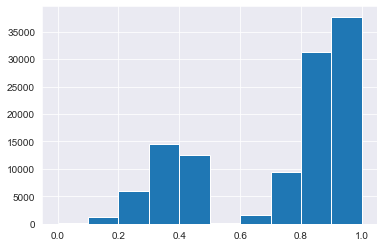

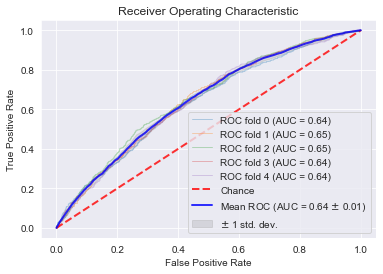

Wall time: 1min 45s


In [10]:
%%time

from feature_discovery import feature_explorer        
        
        
X_vars = list(df.drop(TARGET_COLS,axis=1).columns)

weights = {
'Diabetes - Eye'                          :5,
'Diabetes - Kidney'                       :1,
'Rheumatoid Arthritis'                    :0,
'Breast Cancer Screening'                 :0,
'Colorectal Cancer'                       :0,
'Osteo Screening'                         :0,
'Medication Reconciliation Post Discharge':0,
'Adult BMI'                               :0,
'SNP - Medication'                        :0,
'SNP - Functional Status Assessment'      :0,
'SNP - Pain Screening'                    :0,
'Statin Adherence'                        :0,
'ACEI/ARB Adherence'                      :0,
'Diabetes Adherence'                      :1,
'Statin use in Diabetes'                  :1,
'Medication Therapy Management'           :0,
'Statin Therapy for Patients with CD'     :0,
'Diabetes - Blood Sugar Controlled'       :1
}
y_vars = [i for i in weights.keys() if weights[i] != 0]
# weights = {k:v for (k,v) in weights.items() if k in y_vars}
weights = {k:v for (k,v) in weights.items() if weights[k] != 0}

# Creates the class
diab = feature_explorer(X_vars = X_vars,
                      y_vars=y_vars,
                      fdf=df,
                      name='Diabetes Blood Sugar Controlled',
                      null_value=0,
                      weights = weights,
                      use_complete_targets=True)

# Identifies the features
diab.perform_feature_selection()

# Runs the model
diab.train_model()

# print(diab.qu,diab.ql)
# print(diab.b_tar_val_counts)
# print(diab.tar_describe)
# print()
# display(diab.dfr)
# display(diab.X)
# display(diab.df_m)


In [11]:
# See classification matrix
print(diab.class_summary)

# See confusion matrix
print(diab.confusion_matrix)

True Negative:  24909
False Positive: 12803
False Negative: 17581
True Positive:  20131
[[24909 12803]
 [17581 20131]]


In [12]:
diab.tar_describe

count   114540.000
mean         0.749
std          0.280
min          0.000
25%          0.444
50%          0.889
75%          1.000
max          1.000
Name: COMPOSITE_TARGET, dtype: float64

In [13]:
print(diab.tar_val_counts)
weights

1.000    37712
0.889    31333
0.333    14564
0.444    12440
0.778     9352
0.222     5936
0.667     1590
0.111     1321
0.000      165
0.556      127
Name: COMPOSITE_TARGET, dtype: int64


{'Diabetes - Eye': 5,
 'Diabetes - Kidney': 1,
 'Diabetes Adherence': 1,
 'Statin use in Diabetes': 1,
 'Diabetes - Blood Sugar Controlled': 1}

In [14]:
diab.dfr

,FI,FI - rank,VIF,VIF - rank,r1,LR_Coeff,LR_Sig,LR_Sig - rank
NY_RXDEDUCTIBLE,0.044,11.000,1.344,18.000,14.500,0.256,0.001,9.000
PRIMARY_CARE_VISITS,0.045,10.000,1.335,17.000,13.500,1.792,0.014,10.000
Benefit_Paid_Amt_OTC,0.031,18.000,1.151,10.000,14.000,0.134,0.538,17.000
YOY_DIFF_OUTPATIENTHOSP,0.040,13.000,1.216,13.000,13.000,1.353,0.000,6.000
NY_ASC,0.056,6.000,1.963,20.000,13.000,-1.004,0.000,4.000
NY_PREMIUM,0.031,17.000,1.170,11.000,14.000,0.185,0.212,14.000
YOY_DIFF_PREMIUM,0.032,16.000,1.145,9.000,12.500,-1.042,0.000,7.000
NY_PCP,0.054,7.000,1.311,16.000,11.500,-0.189,0.186,12.000
YOY_DIFF_MOOPINN,0.026,20.000,1.074,4.000,12.000,-0.077,0.762,18.000
SPCLST_BENEFIT_PAID_AMT,0.065,5.000,1.126,6.000,5.500,3.299,0.000,5.000


In [15]:
diab.sig_vars.sort_values('LR_Coeff',ascending=True)

,FI,FI - rank,VIF,VIF - rank,r1,LR_Coeff,LR_Sig,LR_Sig - rank
EMERG_VISITS,0.074,2.000,1.228,14.000,8.000,-2.634,0.000,2.000
YOY_DIFF_PREMIUM,0.032,16.000,1.145,9.000,12.500,-1.042,0.000,7.000
NY_ASC,0.056,6.000,1.963,20.000,13.000,-1.004,0.000,4.000
NY_INPATIENTSTAYMC,0.068,3.000,1.466,19.000,11.000,-0.630,0.000,8.000
Plan_Type_PPO,0.120,1.000,1.271,15.000,8.000,-0.251,0.000,3.000
NY_RXDEDUCTIBLE,0.044,11.000,1.344,18.000,14.500,0.256,0.001,9.000
Age,0.066,4.000,1.033,2.000,3.000,1.315,0.000,1.000
YOY_DIFF_OUTPATIENTHOSP,0.040,13.000,1.216,13.000,13.000,1.353,0.000,6.000
PRIMARY_CARE_VISITS,0.045,10.000,1.335,17.000,13.500,1.792,0.014,10.000
SPCLST_BENEFIT_PAID_AMT,0.065,5.000,1.126,6.000,5.500,3.299,0.000,5.000


In [16]:
diab.ql

0.8888888888888888

In [17]:
diab.b_tar_val_counts

0    76828
1    37712
Name: b_COMPOSITE_TARGET, dtype: int64

0.800    3028
0.200    2054
1.000    1972
0.600    1509
0.400    1159
0.000     278
Name: COMPOSITE_TARGET, dtype: int64
0.000    5000
1.000    5000
Name: b_COMPOSITE_TARGET, dtype: int64


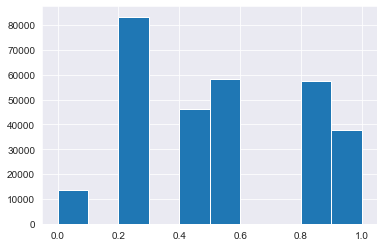

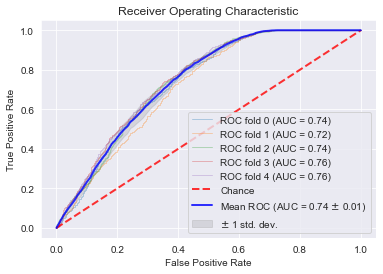

True Negative:  64983
False Positive: 30204
False Negative: 36244
True Positive:  58943
[[64983 30204]
 [36244 58943]]
Wall time: 1min 54s


In [18]:
%%time

from feature_discovery import feature_explorer        
        
        
X_vars = list(df.drop(TARGET_COLS,axis=1).columns)

weights = {
'Diabetes - Eye'                          :1,
'Diabetes - Kidney'                       :1,
'Rheumatoid Arthritis'                    :0,
'Breast Cancer Screening'                 :0,
'Colorectal Cancer'                       :0,
'Osteo Screening'                         :0,
'Medication Reconciliation Post Discharge':0,
'Adult BMI'                               :0,
'SNP - Medication'                        :0,
'SNP - Functional Status Assessment'      :0,
'SNP - Pain Screening'                    :0,
'Statin Adherence'                        :0,
'ACEI/ARB Adherence'                      :0,
'Diabetes Adherence'                      :1,
'Statin use in Diabetes'                  :1,
'Medication Therapy Management'           :0,
'Statin Therapy for Patients with CD'     :0,
'Diabetes - Blood Sugar Controlled'       :1
}
y_vars = [i for i in weights.keys() if weights[i] != 0]
# weights = {k:v for (k,v) in weights.items() if k in y_vars}
weights = {k:v for (k,v) in weights.items() if weights[k] != 0}

# Creates the class
diab2 = feature_explorer(X_vars = X_vars,
                      y_vars=y_vars,
                      fdf=df,
                      name='Diabetes Blood Sugar Controlled',
                      null_value=0,
                      weights = weights,
                      use_complete_targets=False)

# Identifies the features
diab2.perform_feature_selection()

# Runs the model
diab2.train_model()

# print(diab.qu,diab.ql)
# print(diab.b_tar_val_counts)
# print(diab.tar_describe)
# print()
# display(diab.dfr)
# display(diab.X)
# display(diab.df_m)
# See classification matrix
print(diab2.class_summary)

# See confusion matrix
print(diab2.confusion_matrix)

In [19]:
diab2.tar_describe

count   296604.000
mean         0.519
std          0.298
min          0.000
25%          0.200
50%          0.600
75%          0.800
max          1.000
Name: COMPOSITE_TARGET, dtype: float64

In [20]:
diab2.b_tar_val_counts

0    201417
1     95187
Name: b_COMPOSITE_TARGET, dtype: int64

1.000    5000
0.000    5000
Name: COMPOSITE_TARGET, dtype: int64
1.000    5000
0.000    5000
Name: b_COMPOSITE_TARGET, dtype: int64


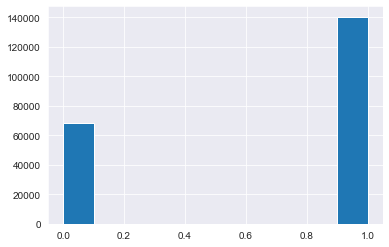

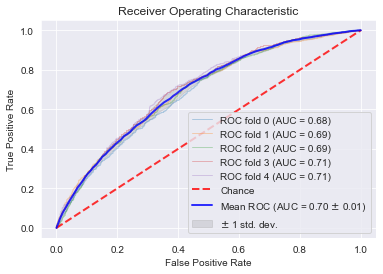

True Negative:  45152
False Positive: 22945
False Negative: 26455
True Positive:  41642
[[45152 22945]
 [26455 41642]]
Wall time: 1min 32s


In [21]:
%%time

from feature_discovery import feature_explorer        
        
        
X_vars = list(df.drop(TARGET_COLS,axis=1).columns)

weights = {
'Diabetes - Eye'                          :1,
'Diabetes - Kidney'                       :0,
'Rheumatoid Arthritis'                    :0,
'Breast Cancer Screening'                 :0,
'Colorectal Cancer'                       :0,
'Osteo Screening'                         :0,
'Medication Reconciliation Post Discharge':0,
'Adult BMI'                               :0,
'SNP - Medication'                        :0,
'SNP - Functional Status Assessment'      :0,
'SNP - Pain Screening'                    :0,
'Statin Adherence'                        :0,
'ACEI/ARB Adherence'                      :0,
'Diabetes Adherence'                      :0,
'Statin use in Diabetes'                  :0,
'Medication Therapy Management'           :0,
'Statin Therapy for Patients with CD'     :0,
'Diabetes - Blood Sugar Controlled'       :0
}
y_vars = [i for i in weights.keys() if weights[i] != 0]
# weights = {k:v for (k,v) in weights.items() if k in y_vars}
weights = {k:v for (k,v) in weights.items() if weights[k] != 0}

# Creates the class
diab2 = feature_explorer(X_vars = X_vars,
                      y_vars=y_vars,
                      fdf=df,
                      name='Diabetes Blood Sugar Controlled',
                      null_value=0,
                      weights = weights,
                      use_complete_targets=False,
                      use_sig = False)


# Identifies the features
diab2.perform_feature_selection()

# Runs the model
diab2.train_model()

# print(diab.qu,diab.ql)
# print(diab.b_tar_val_counts)
# print(diab.tar_describe)
# print()
# display(diab.dfr)
# display(diab.X)
# display(diab.df_m)
# See classification matrix
print(diab2.class_summary)

# See confusion matrix
print(diab2.confusion_matrix)

In [ ]:
diab2.df_fs

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(diab2.df_fs)

In [ ]:
pd.DataFrame(pca.components_)